# 1. Business Understanding

- Mengembangkan Model SImulasi Otomatisasi HIdroponik mas dengan model Prophet dan Arima
- Membandingkan 2 Metode Algoritma Prophet dan ARIMA mana yang terbaik dan efektif.
- Mengembangkan Aplikasi Simulasi Hidroponik (HydroSim) untuk mlakukan simulasi otomasisasi hidroponik tanaman selada dengan menggunakan model terbaik

# 2. Data Understanding

## Import All Library or Package

In [19]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.9 MB/s eta 0:00:00


In [20]:
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from tabulate import tabulate
from sklearn.metrics import confusion_matrix
import joblib
import optuna

## Load Dataset

In [ ]:
df_train = pd.read_csv("/content/DataFieldFULLSIOHITrainFULLPattern01072024.csv")
df_test = pd.read_csv("/content/DataFieldFULLSIOHITest01072024.csv")

## EDA

In [ ]:
# Display Head Data from Dataset Train
df_train.head()

,day,hole,time,temperature,humidity,light,pH,EC,TDS,WaterTemp,Label,LeafCount
0,1,1,9.19,26.8,72,17820,7.2,677,340,26.1,Selada,3
1,1,2,9.23,26.6,72,16490,7.2,677,338,26.1,Selada,3
2,1,3,9.27,26.4,72,15160,7.2,678,334,26.1,Selada,3
3,1,4,9.31,26.2,72,13830,7.2,677,338,26.1,Selada,3
4,1,5,9.35,26.2,72,12500,7.2,673,340,26.1,Selada,3


In [ ]:
# Display Head Data from Dataset Test
df_test.head()

,day,hole,time,temperature,humidity,light,pH,EC,TDS,WaterTemp,Label,LeafCount
0,1,1,9.19,26.8,72,17820,7.1,918,459,26.1,Selada,3
1,1,2,9.23,26.6,72,16490,7.1,918,459,26.1,Selada,3
2,1,3,9.27,26.4,72,15160,7.1,915,454,26.1,Selada,3
3,1,4,9.31,26.2,72,13830,7.1,915,457,26.1,Selada,3
4,1,5,9.35,26.2,72,12500,7.1,918,461,26.1,Selada,4


In [ ]:
# Display Banyak Data masing masing Dataframe
print("Banyak data dari data train", len(df_train))
print("Banyak data dari data test", len(df_test))

Banyak data dari data train 8000
Banyak data dari data test 6400


In [ ]:
# Display tipe data dari Data Train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          8000 non-null   int64  
 1   hole         8000 non-null   int64  
 2   time         8000 non-null   float64
 3   temperature  8000 non-null   float64
 4   humidity     8000 non-null   int64  
 5   light        8000 non-null   int64  
 6   pH           8000 non-null   float64
 7   EC           8000 non-null   int64  
 8   TDS          8000 non-null   int64  
 9   WaterTemp    8000 non-null   float64
 10  Label        8000 non-null   object 
 11  LeafCount    8000 non-null   int64  
dtypes: float64(4), int64(7), object(1)
memory usage: 750.1+ KB


In [ ]:
# Check missing data

missing_data = pd.DataFrame({'total_missing': df_train.isnull().sum(),
                             'perc_missing': (df_train.isnull().sum()/2634)*100})

missing_data

,total_missing,perc_missing
day,0,0.0
hole,0,0.0
time,0,0.0
temperature,0,0.0
humidity,0,0.0
light,0,0.0
pH,0,0.0
EC,0,0.0
TDS,0,0.0
WaterTemp,0,0.0


In [ ]:
# Check missing data

missing_data = pd.DataFrame({'total_missing': df_test.isnull().sum(),
                             'perc_missing': (df_test.isnull().sum()/2634)*100})

missing_data

,total_missing,perc_missing
day,0,0.0
hole,0,0.0
time,0,0.0
temperature,0,0.0
humidity,0,0.0
light,0,0.0
pH,0,0.0
EC,0,0.0
TDS,0,0.0
WaterTemp,0,0.0


In [ ]:
df_train.describe()

,day,hole,time,temperature,humidity,light,pH,EC,TDS,WaterTemp,LeafCount
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,20.500000,5.000000,12.878269,27.147687,69.978750,30548.134375,7.185200,1332.533625,665.670500,27.194700,8.366000
std,11.544118,2.828604,2.761630,1.958960,16.376334,17976.792892,0.304376,493.701284,246.395326,2.946802,4.016536
min,1.000000,1.000000,7.370000,23.100000,40.000000,9003.000000,6.400000,514.000000,258.000000,22.300000,3.000000
25%,10.750000,3.000000,10.945000,25.700000,57.000000,17180.000000,6.900000,686.000000,348.000000,24.900000,5.000000
50%,20.500000,5.000000,13.225000,26.800000,69.000000,28830.000000,7.200000,1538.000000,760.000000,26.500000,8.000000
75%,30.250000,7.000000,15.405000,28.100000,84.000000,41422.500000,7.300000,1599.000000,799.000000,28.900000,11.000000
max,40.000000,10.000000,17.020000,32.600000,99.000000,168770.000000,8.200000,2467.000000,1758.000000,34.100000,20.000000


In [ ]:
# Drop uninmportant column
df_train = df_train.drop(columns=['Label'])
df_test = df_test.drop(columns=['Label'])

In [ ]:
# Display Correlation Matrix
cor_matrix = df_train.corr()
cor_matrix

,day,hole,time,temperature,humidity,light,pH,EC,TDS,WaterTemp,LeafCount
day,1.000000e+00,1.249092e-16,0.003883,-0.171041,0.144791,-0.107481,0.281429,0.829152,0.830171,-0.537363,0.890994
hole,1.249092e-16,1.000000e+00,0.029839,0.013435,0.000918,-0.025341,-0.028576,-0.125153,-0.124434,-0.012963,0.064658
time,3.883354e-03,2.983932e-02,1.000000,0.235844,-0.513122,0.364059,0.225903,0.008172,0.007146,0.457679,0.008695
temperature,-1.710405e-01,1.343533e-02,0.235844,1.000000,-0.362850,0.210620,0.023773,-0.144243,-0.144734,0.408470,-0.168226
humidity,1.447911e-01,9.176021e-04,-0.513122,-0.362850,1.000000,-0.354230,-0.046467,0.122619,0.121974,-0.421257,0.113101
light,-1.074807e-01,-2.534086e-02,0.364059,0.210620,-0.354230,1.000000,0.003685,-0.121969,-0.120875,0.365463,-0.071180
pH,2.814291e-01,-2.857631e-02,0.225903,0.023773,-0.046467,0.003685,1.000000,0.295695,0.294266,-0.073158,0.152390
EC,8.291518e-01,-1.251526e-01,0.008172,-0.144243,0.122619,-0.121969,0.295695,1.000000,0.997981,-0.434209,0.718760
TDS,8.301709e-01,-1.244343e-01,0.007146,-0.144734,0.121974,-0.120875,0.294266,0.997981,1.000000,-0.435360,0.720149
WaterTemp,-5.373625e-01,-1.296301e-02,0.457679,0.408470,-0.421257,0.365463,-0.073158,-0.434209,-0.435360,1.000000,-0.489908


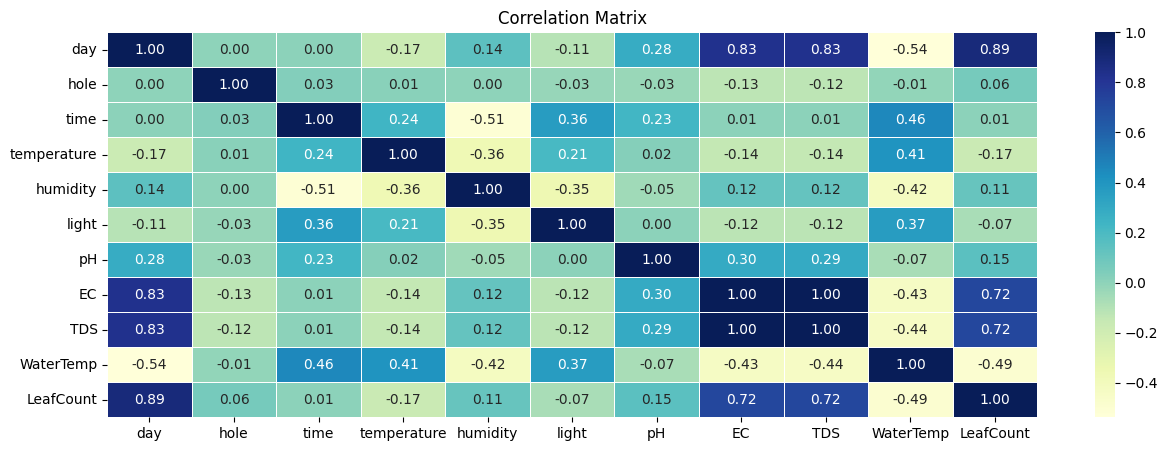

In [ ]:
# Heatmap of the correlation matrix
plt.figure(figsize=(15, 5))
sns.heatmap(cor_matrix, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

## Visualization

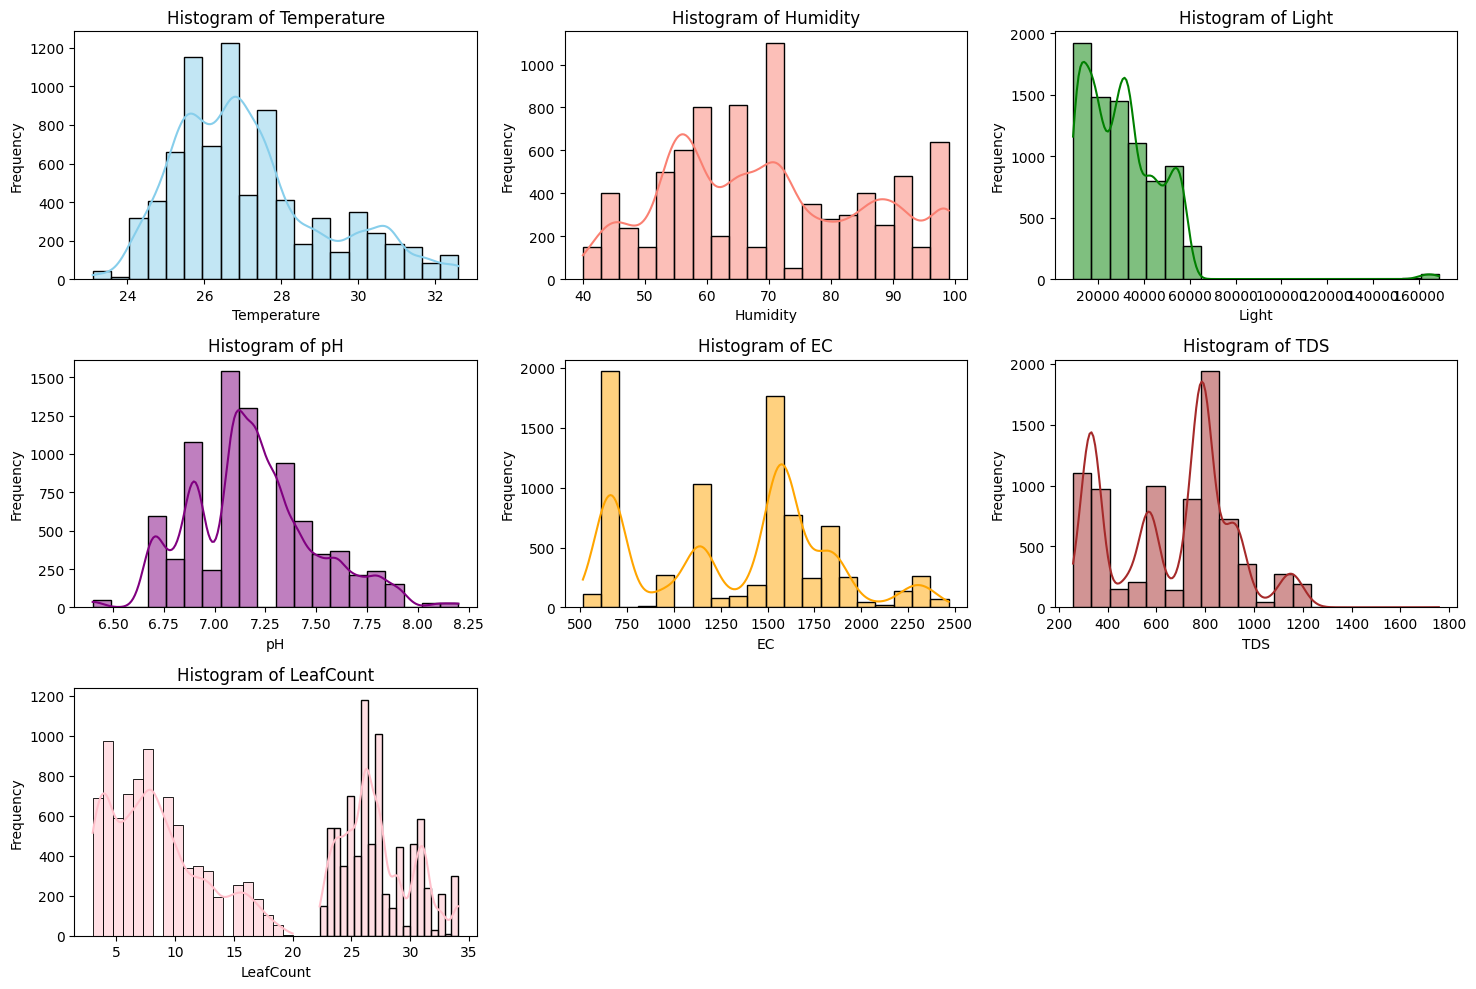

In [ ]:
# Plotting histograms
plt.figure(figsize=(15, 10))

# Histogram for 'temperature'
plt.subplot(3, 3, 1)
sns.histplot(df_train['temperature'], bins=20, kde=True, color='skyblue')
plt.title('Histogram of Temperature')
plt.xlabel('Temperature')
plt.ylabel('Frequency')

# Histogram for 'humidity'
plt.subplot(3, 3, 2)
sns.histplot(df_train['humidity'], bins=20, kde=True, color='salmon')
plt.title('Histogram of Humidity')
plt.xlabel('Humidity')
plt.ylabel('Frequency')

# Histogram for 'light'
plt.subplot(3, 3, 3)
sns.histplot(df_train['light'], bins=20, kde=True, color='green')
plt.title('Histogram of Light')
plt.xlabel('Light')
plt.ylabel('Frequency')

# Histogram for 'pH'
plt.subplot(3, 3, 4)
sns.histplot(df_train['pH'], bins=20, kde=True, color='purple')
plt.title('Histogram of pH')
plt.xlabel('pH')
plt.ylabel('Frequency')

# Histogram for 'EC'
plt.subplot(3, 3, 5)
sns.histplot(df_train['EC'], bins=20, kde=True, color='orange')
plt.title('Histogram of EC')
plt.xlabel('EC')
plt.ylabel('Frequency')

# Histogram for 'TDS'
plt.subplot(3, 3, 6)
sns.histplot(df_train['TDS'], bins=20, kde=True, color='brown')
plt.title('Histogram of TDS')
plt.xlabel('TDS')
plt.ylabel('Frequency')

# Histogram for 'WaterTemp'
plt.subplot(3, 3, 7)
sns.histplot(df_train['WaterTemp'], bins=20, kde=True, color='pink')
plt.title('Histogram of WaterTemp')
plt.xlabel('WaterTemp')
plt.ylabel('Frequency')

# Histogram for 'LeafCount'
plt.subplot(3, 3, 7)
sns.histplot(df_train['LeafCount'], bins=20, kde=True, color='pink')
plt.title('Histogram of LeafCount')
plt.xlabel('LeafCount')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Visualisasi Terhadap Hari

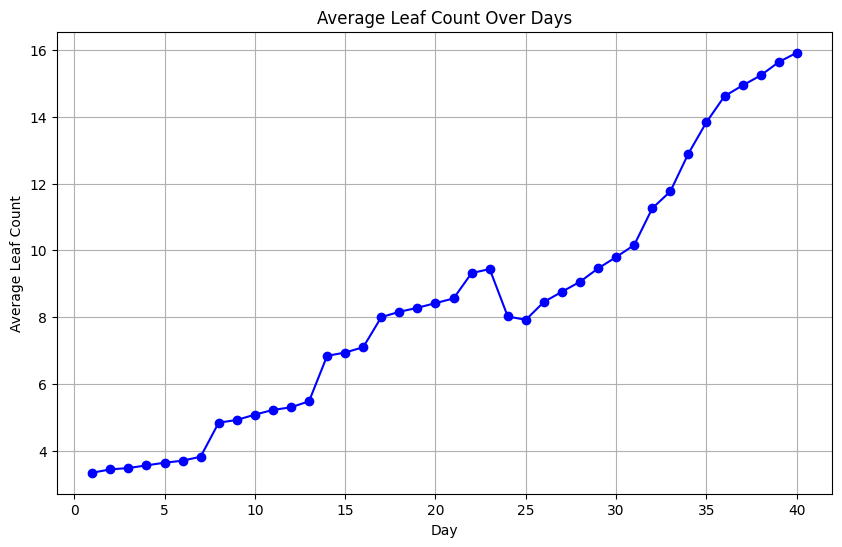

In [ ]:
# Group by 'day' and calculate the mean of 'LeafCount'
average_leaf_count = df_train.groupby('day')['LeafCount'].mean().reset_index()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(average_leaf_count['day'], average_leaf_count['LeafCount'], marker='o', linestyle='-', color='b')

# Adding titles and labels
plt.title('Average Leaf Count Over Days')
plt.xlabel('Day')
plt.ylabel('Average Leaf Count')

# Display the plot
plt.grid(True)
plt.show()

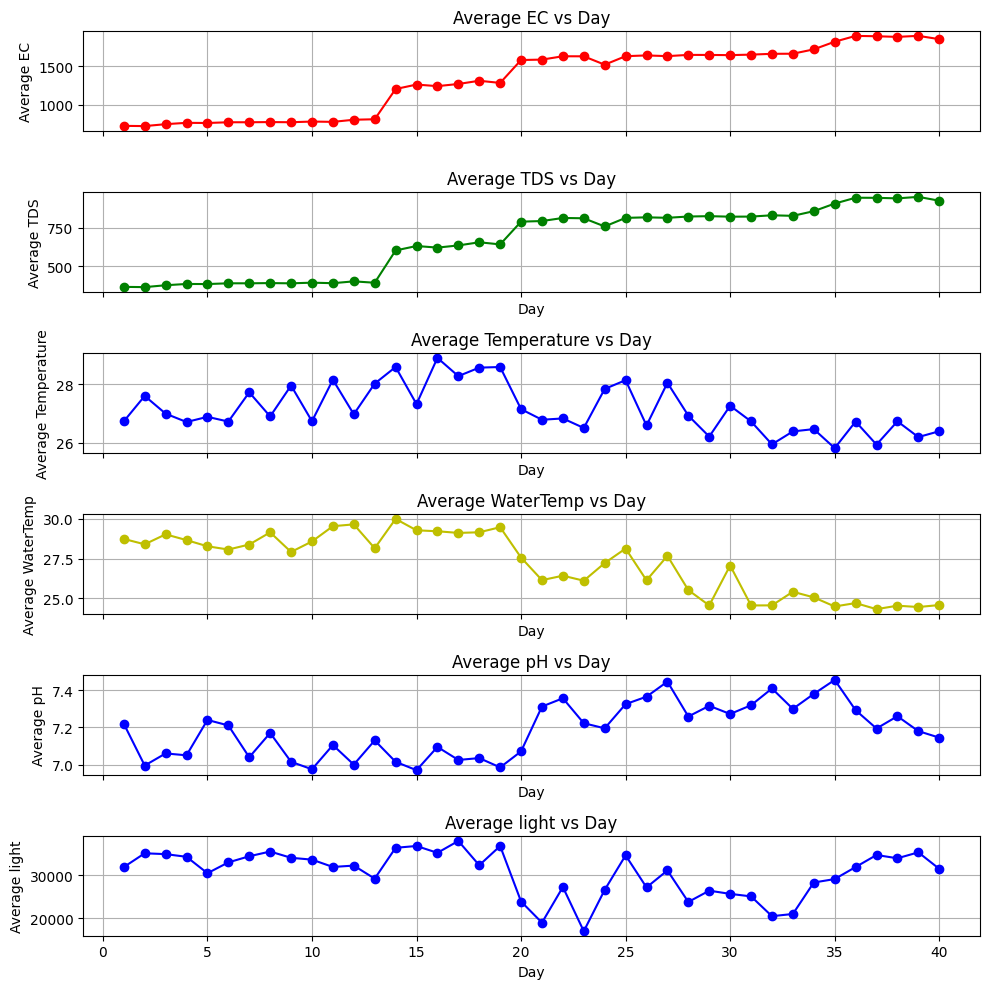

In [ ]:
# Group by 'day' and calculate the mean of 'EC' and 'TDS'
average_values = df_train.groupby('day')[['EC', 'TDS', 'temperature', 'WaterTemp', 'pH', 'light']].mean().reset_index()

# Creating the subplots
fig, axs = plt.subplots(6, 1, figsize=(10, 10), sharex=True)

# Plotting average EC vs day
axs[0].plot(average_values['day'], average_values['EC'], marker='o', linestyle='-', color='r')
axs[0].set_title('Average EC vs Day')
axs[0].set_ylabel('Average EC')
axs[0].grid(True)

# Plotting average TDS vs day
axs[1].plot(average_values['day'], average_values['TDS'], marker='o', linestyle='-', color='g')
axs[1].set_title('Average TDS vs Day')
axs[1].set_xlabel('Day')
axs[1].set_ylabel('Average TDS')
axs[1].grid(True)

# Plotting average temperature vs day
axs[2].plot(average_values['day'], average_values['temperature'], marker='o', linestyle='-', color='b')
axs[2].set_title('Average Temperature vs Day')
axs[2].set_xlabel('Day')
axs[2].set_ylabel('Average Temperature')
axs[2].grid(True)

# Plotting average WaterTemp vs day
axs[3].plot(average_values['day'], average_values['WaterTemp'], marker='o', linestyle='-', color='y')
axs[3].set_title('Average WaterTemp vs Day')
axs[3].set_xlabel('Day')
axs[3].set_ylabel('Average WaterTemp')
axs[3].grid(True)

# Plotting average pH vs day
axs[4].plot(average_values['day'], average_values['pH'], marker='o', linestyle='-', color='b')
axs[4].set_title('Average pH vs Day')
axs[4].set_xlabel('Day')
axs[4].set_ylabel('Average pH')
axs[4].grid(True)

# Plotting average light vs day
axs[5].plot(average_values['day'], average_values['light'], marker='o', linestyle='-', color='b')
axs[5].set_title('Average light vs Day')
axs[5].set_xlabel('Day')
axs[5].set_ylabel('Average light')
axs[5].grid(True)

# Displaying the plots
plt.tight_layout()
plt.show()

# 3. Data Preparation

In [ ]:
# Make a Backup dataframe
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

## Make a column datetime

This column is very important to make model for Forecasting

### Make column Time to the actually time column

In [ ]:
df_train_copy['time']
df_test_copy['time']

0        9.19
1        9.23
2        9.27
3        9.31
4        9.35
        ...  
6395    16.38
6396    16.42
6397    16.43
6398    16.44
6399    16.45
Name: time, Length: 6400, dtype: float64

In [ ]:
# Tambahkan "0" di depan nilai yang hanya satu digit di bagian jam
df_train_copy['time'] = df_train_copy['time'].apply(lambda x: '{:.2f}'.format(x))
df_test_copy['time'] = df_test_copy['time'].apply(lambda x: '{:.2f}'.format(x))

# Konversi 'time' ke format waktu yang benar
df_train_copy['time'] = pd.to_datetime(df_train_copy['time'], format='%H.%M').dt.time
df_test_copy['time'] = pd.to_datetime(df_test_copy['time'], format='%H.%M').dt.time

In [ ]:
df_train_copy.head(5)

,day,hole,time,temperature,humidity,light,pH,EC,TDS,WaterTemp,LeafCount
0,1,1,09:19:00,26.8,72,17820,7.2,677,340,26.1,3
1,1,2,09:23:00,26.6,72,16490,7.2,677,338,26.1,3
2,1,3,09:27:00,26.4,72,15160,7.2,678,334,26.1,3
3,1,4,09:31:00,26.2,72,13830,7.2,677,338,26.1,3
4,1,5,09:35:00,26.2,72,12500,7.2,673,340,26.1,3


### Make a column Datetime

In [ ]:
df_train_prep = df_train_copy.copy()
df_test_prep = df_test_copy.copy()

In [ ]:
df_train_prep = df_train_prep[['day', 'time', 'LeafCount']]
df_test_prep = df_test_prep[['day', 'time', 'LeafCount']]

In [ ]:
# Tentukan tanggal awal
start_date = pd.to_datetime('2024-07-01')

In [ ]:
# Ubah kolom 'time' menjadi string
df_train_prep['time'] = df_train_prep['time'].astype(str)
df_test_prep['time'] = df_test_prep['time'].astype(str)

# Buat kolom 'datetime' dengan menambahkan 'day' ke tanggal awal dan menggabungkan dengan 'time'
df_train_prep['datetime'] = df_train_prep.apply(lambda row: start_date + pd.Timedelta(days=row['day'] - 1) + pd.to_timedelta(row['time']), axis=1)
df_test_prep['datetime'] = df_test_prep.apply(lambda row: start_date + pd.Timedelta(days=row['day'] - 1) + pd.to_timedelta(row['time']), axis=1)


In [ ]:
print(df_train_prep.head())

   day      time  LeafCount            datetime
0    1  09:19:00          3 2024-07-01 09:19:00
1    1  09:23:00          3 2024-07-01 09:23:00
2    1  09:27:00          3 2024-07-01 09:27:00
3    1  09:31:00          3 2024-07-01 09:31:00
4    1  09:35:00          3 2024-07-01 09:35:00


## Data Pre-Processing

In [ ]:
df_test_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   day        6400 non-null   int64         
 1   time       6400 non-null   object        
 2   LeafCount  6400 non-null   int64         
 3   datetime   6400 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 200.1+ KB


In [ ]:
# Convert to correct data types
df_train_prep['day'] = df_train_prep['day'].astype(int)
df_train_prep['time'] = df_train_prep['time'].astype(str)
df_train_prep['LeafCount'] = df_train_prep['LeafCount'].astype(int)

# Convert to correct data types
df_test_prep['day'] = df_test_prep['day'].astype(int)
df_test_prep['time'] = df_test_prep['time'].astype(str)
df_test_prep['LeafCount'] = df_test_prep['LeafCount'].astype(int)

In [ ]:
# Convert to correct data types
df_train_copy['day'] = df_train_copy['day'].astype(int)
df_train_copy['time'] = df_train_copy['time'].astype(str)
df_train_copy['LeafCount'] = df_train_copy['LeafCount'].astype(int)

df_test_copy['day'] = df_test_copy['day'].astype(int)
df_test_copy['time'] = df_test_copy['time'].astype(str)
df_test_copy['LeafCount'] = df_test_copy['LeafCount'].astype(int)

In [ ]:
# Merge the 'datetime' column from df_prep into df_copy
df_train_model = pd.merge(df_train_copy, df_train_prep[['day', 'time', 'LeafCount', 'datetime']], on=['day', 'time', 'LeafCount'], how='inner')
df_test_model = pd.merge(df_test_copy, df_test_prep[['day', 'time', 'LeafCount', 'datetime']], on=['day', 'time', 'LeafCount'], how='inner')

# Debug: Check the result of the merge
print("df_model after merge:")
print(df_train_model.head())

df_model after merge:
   day  hole      time  temperature  humidity  light   pH   EC  TDS  \
0    1     1  09:19:00         26.8        72  17820  7.2  677  340   
1    1     1  09:19:00         26.8        72  17820  7.2  677  340   
2    1     1  09:19:00         26.8        72  17820  7.2  677  340   
3    1     1  09:19:00         26.8        72  17820  7.2  677  340   
4    1     2  09:23:00         26.6        72  16490  7.2  677  338   

   WaterTemp  LeafCount            datetime  
0       26.1          3 2024-07-01 09:19:00  
1       26.1          3 2024-07-01 09:19:00  
2       26.1          3 2024-07-01 09:19:00  
3       26.1          3 2024-07-01 09:19:00  
4       26.1          3 2024-07-01 09:23:00  


In [ ]:
# Drop duplicates
df_train_model = df_train_model.drop_duplicates(subset=['day', 'time', 'LeafCount'])
df_test_model = df_test_model.drop_duplicates(subset=['day', 'time', 'LeafCount'])

In [ ]:
# Set the 'datetime' column as the index and sort it
df_train_model.set_index('datetime', inplace=True)
df_train_model = df_train_model.sort_index()

# Set the 'datetime' column as the index and sort it
df_test_model.set_index('datetime', inplace=True)
df_test_model = df_test_model.sort_index()

In [ ]:
# Ensure that the data is sorted by datetime
df_train_model = df_train_model.sort_index()
df_test_model = df_test_model.sort_index()

In [ ]:
# save dataframe to csv
df_train_model.to_csv('dataset_train_final.csv')
df_test_model.to_csv('dataset_test_final.csv')

# 4. Modeling & Evaluation

In [40]:
df_train = pd.read_csv("/content/dataset_train_final.csv")
df_test = pd.read_csv("/content/dataset_test_final.csv")

In [41]:
# Convert datetime to datetime format and set as index
df_train['datetime'] = pd.to_datetime(df_train['datetime'])
df_train.set_index('datetime', inplace=True)

df_test['datetime'] = pd.to_datetime(df_test['datetime'])
df_test.set_index('datetime', inplace=True)

In [42]:
print("Banyak data train", len(df_train))
print("Banyak data test", len(df_test))

Banyak data train 5283
Banyak data test 3023


In [43]:
# Calculate and print the total number of unique days in the dataset
total_days = df_train.index.date.max() - df_train.index.date.min()
print(f'Total days in the training dataset: {total_days.days + 1}')  # Adding 1 to include the start day in the count

Total days in the training dataset: 40


### ARIMA Model (BASE)

In [44]:
# Train ARIMA model with default hyperparameters
model_default_arima = ARIMA(df_train['LeafCount'], order=(1, 1, 1))
model_default_fit = model_default_arima.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [45]:
# Forecast for the test set range
forecast_default = model_default_fit.predict(start=df_test.index[0], end=df_test.index[-1])
forecast_default = forecast_default[:len(df_test)]

# Evaluate default model
rmse_default_arima = np.sqrt(mean_squared_error(df_test['LeafCount'], forecast_default))
mae_default_arima = mean_absolute_error(df_test['LeafCount'], forecast_default)

print(f'Default Model RMSE: {rmse_default_arima}')
print(f'Default Model MAE: {mae_default_arima}')

Default Model RMSE: 3.1893160684801187
Default Model MAE: 2.136866202212184


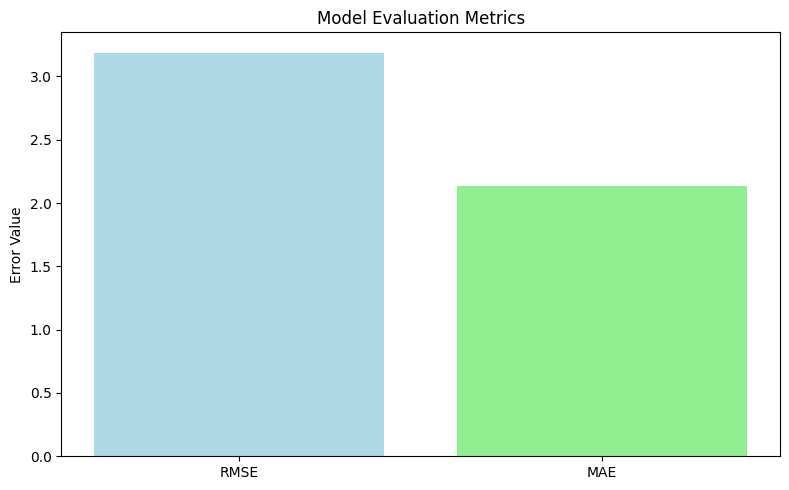

In [46]:
# Visualize RMSE and MAE values as a bar chart
rmse_default_arima = 3.1893160684801187  # Placeholder value for RMSE
mae_default_arima = 2.136866202212184    # Placeholder value for MAE

# Create a bar chart
plt.figure(figsize=(8, 5))
metrics = ['RMSE', 'MAE']
values = [rmse_default_arima, mae_default_arima]
plt.bar(metrics, values, color=['lightblue', 'lightgreen'])

# Add labels and title
plt.title('Model Evaluation Metrics')
plt.ylabel('Error Value')
plt.tight_layout()

# Show the plot
plt.show()

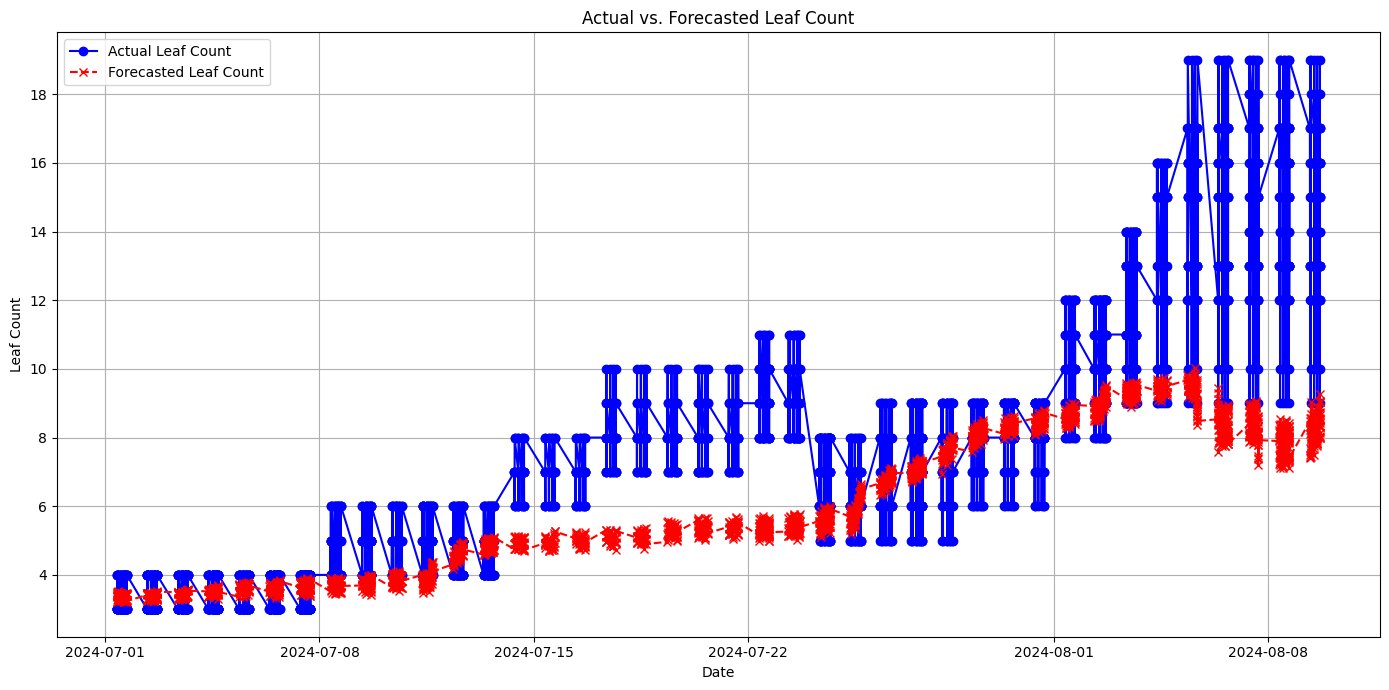

In [47]:
# Plot actual vs. forecasted values
plt.figure(figsize=(14, 7))
plt.plot(df_test.index, df_test['LeafCount'], label='Actual Leaf Count', color='blue', marker='o')
plt.plot(df_test.index, forecast_default, label='Forecasted Leaf Count', color='red', linestyle='--', marker='x')

# Labels and title
plt.title('Actual vs. Forecasted Leaf Count')
plt.xlabel('Date')
plt.ylabel('Leaf Count')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

## ARIMA Hyperparameter Tunning

In [48]:
# Fine-tuning hyperparameters (example: ARIMA(p,d,q) with custom parameters)
model_tuned = ARIMA(df_train['LeafCount'], order=(2, 1, 2))  # Replace (2, 1, 2) with your best parameters after tuning
model_tuned_fit = model_tuned.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [49]:
# Forecast for the test set range
forecast_tuned = model_tuned_fit.predict(start=df_test.index[0], end=df_test.index[-1])
forecast_tuned = forecast_tuned[:len(df_test)]

# Evaluate fine-tuned model
rmse_tuned_arima = np.sqrt(mean_squared_error(df_test['LeafCount'], forecast_tuned))
mae_tuned_arima = mean_absolute_error(df_test['LeafCount'], forecast_tuned)

print(f'Tuned Model RMSE: {rmse_tuned_arima}')
print(f'Tuned Model MAE: {mae_tuned_arima}')

Tuned Model RMSE: 3.1877459796325156
Tuned Model MAE: 2.1372341692159247


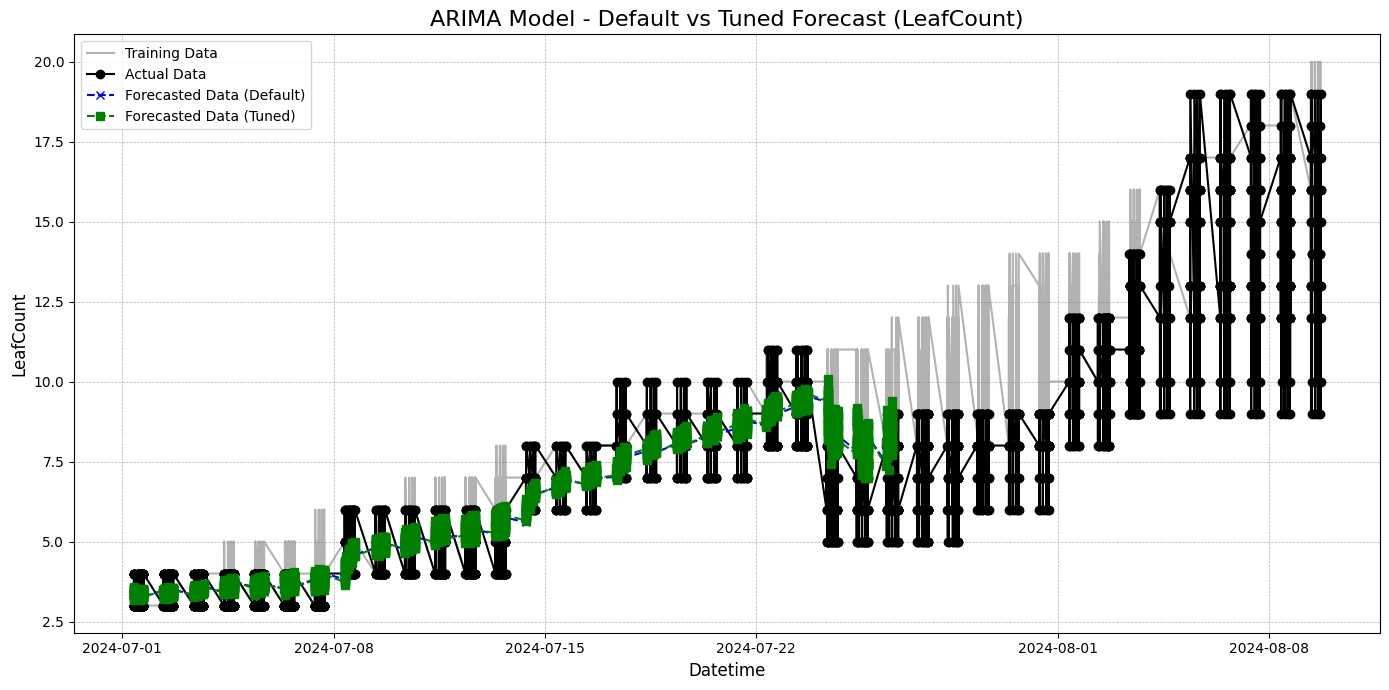

In [ ]:
# Enhanced plot comparison for better readability
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(df_train['LeafCount'], label='Training Data', linestyle='-', color='gray', alpha=0.6)

# Plot actual data with markers
plt.plot(df_test['LeafCount'], label='Actual Data', linestyle='-', marker='o', color='black')

# Plot forecasted data for default model
plt.plot(forecast_default, label='Forecasted Data (Default)', linestyle='--', marker='x', color='blue')

# Plot forecasted data for tuned model
plt.plot(forecast_tuned, label='Forecasted Data (Tuned)', linestyle='--', marker='s', color='green')

# Add gridlines and legend
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper left')

# Add title and labels
plt.title('ARIMA Model - Default vs Tuned Forecast (LeafCount)', fontsize=16)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('LeafCount', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

## Prophet Model (BASE)

In [4]:
# Convert datetime to datetime format
df_train['datetime'] = pd.to_datetime(df_train['datetime'])
df_test['datetime'] = pd.to_datetime(df_test['datetime'])

# Prepare training data for Prophet
df_train_prophet = df_train[['datetime', 'LeafCount', 'hole', 'temperature', 'humidity', 'light', 'pH', 'EC', 'TDS', 'WaterTemp']].copy()
df_train_prophet.rename(columns={'datetime': 'ds', 'LeafCount': 'y'}, inplace=True)

# Prepare test data for evaluation
df_test_prophet = df_test[['datetime', 'LeafCount', 'hole', 'temperature', 'humidity', 'light', 'pH', 'EC', 'TDS', 'WaterTemp']].copy()
df_test_prophet.rename(columns={'datetime': 'ds', 'LeafCount': 'y'}, inplace=True)

In [5]:
df_train_prophet

,ds,y,hole,temperature,humidity,light,pH,EC,TDS,WaterTemp
0,2024-07-01 08:55:00,3,1,25.3,92,21910,7.0,660,330,23.1
1,2024-07-01 08:57:00,3,2,25.3,92,21910,7.0,660,330,23.1
2,2024-07-01 08:59:00,3,3,25.5,92,21060,7.8,984,492,26.1
3,2024-07-01 08:59:00,4,3,25.5,92,21060,7.0,652,326,23.1
4,2024-07-01 09:02:00,3,4,25.7,92,28330,7.0,656,328,23.1
...,...,...,...,...,...,...,...,...,...,...
5278,2024-08-09 16:44:00,18,9,25.6,44,12820,7.5,1851,930,26.3
5279,2024-08-09 16:44:00,16,9,25.6,44,12820,7.5,1851,930,23.9
5280,2024-08-09 16:45:00,15,10,25.4,44,16810,7.5,1886,943,23.9
5281,2024-08-09 16:45:00,18,10,25.4,44,16810,7.5,1886,943,23.9


In [6]:
# Add cap for logistic growth
df_train_prophet['cap'] = 18

In [7]:
# Initialize Prophet model with regressors
model = Prophet(growth='logistic')
model.add_regressor('hole')
model.add_regressor('temperature')
model.add_regressor('humidity')
model.add_regressor('light')
model.add_regressor('pH')
model.add_regressor('EC')
model.add_regressor('TDS')
model.add_regressor('WaterTemp')

# Fit the model
model.fit(df_train_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp95dtlaol/od614l2z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp95dtlaol/6em1qj7f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26768', 'data', 'file=/tmp/tmp95dtlaol/od614l2z.json', 'init=/tmp/tmp95dtlaol/6em1qj7f.json', 'output', 'file=/tmp/tmp95dtlaol/prophet_modelnav8x35n/prophet_model-20241119030428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:04:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:04:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [8]:
# Create future DataFrame for predictions
future = model.make_future_dataframe(periods=len(df_test_prophet), freq='D')  # Match the test data period
future['cap'] = 18

In [9]:
# Fill in the future DataFrame with the last known values of the regressors from df_test_prophet
future['hole'] = df_test_prophet['hole'].iloc[-1]
future['temperature'] = df_test_prophet['temperature'].iloc[-1]
future['humidity'] = df_test_prophet['humidity'].iloc[-1]
future['light'] = df_test_prophet['light'].iloc[-1]
future['pH'] = df_test_prophet['pH'].iloc[-1]
future['EC'] = df_test_prophet['EC'].iloc[-1]
future['TDS'] = df_test_prophet['TDS'].iloc[-1]
future['WaterTemp'] = df_test_prophet['WaterTemp'].iloc[-1]

In [14]:
# Make predictions
forecast = model.predict(future)

# Ensure forecast includes only test dates
forecast_test = forecast[forecast['ds'].isin(df_test_prophet['ds'])]

# Merge forecast with actuals for evaluation using suffixes to avoid overlap
merged = pd.merge(df_test_prophet, forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1789: RuntimeWarning: overflow encountered in exp
  sample_trends = cap / (1 + np.exp(-k_t * (t_time - m_t)))


In [15]:
# Calculate evaluation metrics
rmse_prophet = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))
mae_prophet = mean_absolute_error(merged['y'], merged['yhat'])

# Display evaluation results
print(f"RMSE: {rmse_prophet}")
print(f"MAE: {mae_prophet}")

RMSE: 1.798066648916837
MAE: 1.4573932363431232


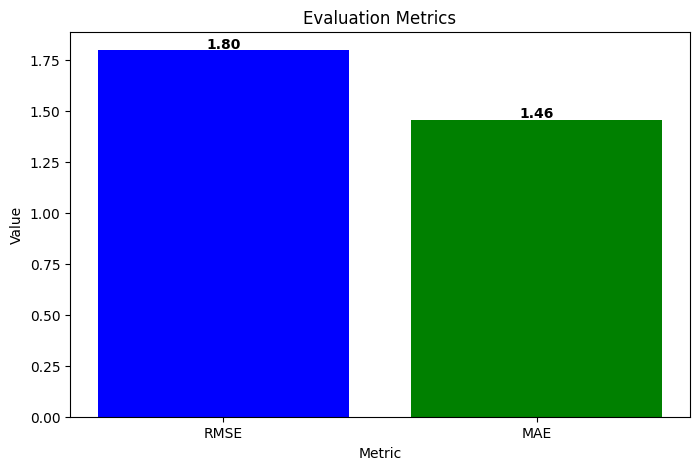

In [16]:
# Evaluation metrics
metrics = ['RMSE', 'MAE']
values = [rmse_prophet, mae_prophet]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green'])

# Add title and labels
plt.title('Evaluation Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')

# Display the values on the bars
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', fontweight='bold')

# Show the plot
plt.show()

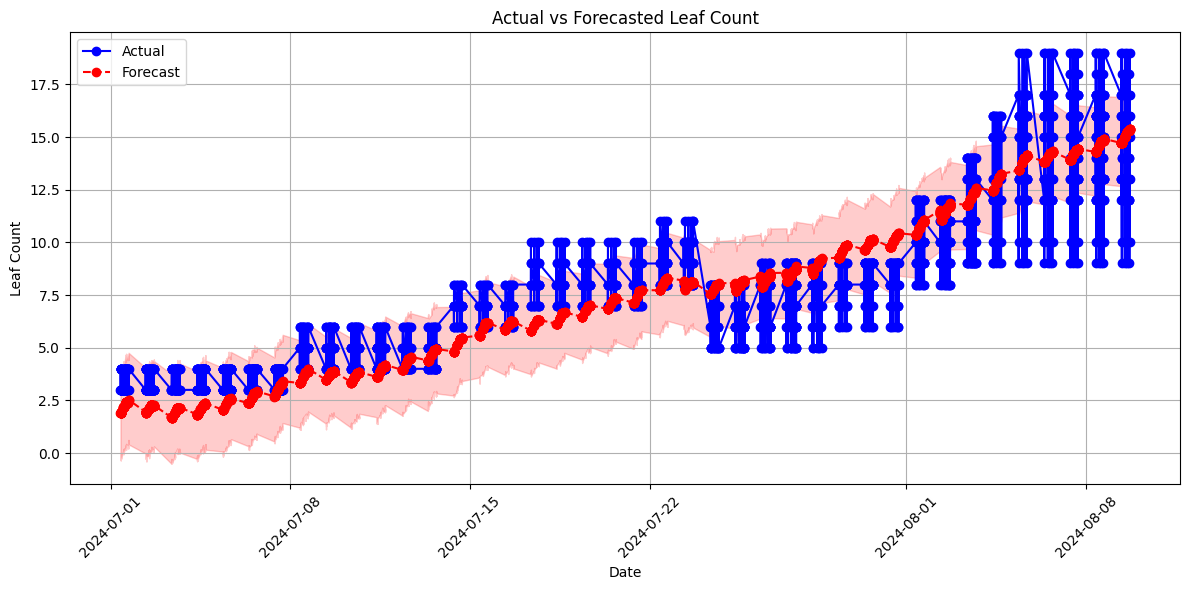

In [17]:
# Plot the results
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(merged['ds'], merged['y'], marker='o', linestyle='-', color='blue', label='Actual')

# Plot forecasted values
plt.plot(merged['ds'], merged['yhat'], marker='o', linestyle='--', color='red', label='Forecast')

# Plot the uncertainty intervals
plt.fill_between(merged['ds'], merged['yhat_lower'], merged['yhat_upper'], color='red', alpha=0.2)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Leaf Count')
plt.title('Actual vs Forecasted Leaf Count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Save the model to a file
joblib.dump(model, 'prophet_model.pkl')

['prophet_model.pkl']

## Prophet Model (Hyperparameter Tunning)

In [22]:
# Convert datetime columns to datetime format
df_train['datetime'] = pd.to_datetime(df_train['datetime'])
df_test['datetime'] = pd.to_datetime(df_test['datetime'])

In [23]:
# Prepare training data for Prophet
df_train_prophet_default = df_train[['datetime', 'LeafCount', 'hole', 'temperature', 'humidity', 'light', 'pH', 'EC', 'TDS', 'WaterTemp']].copy()
df_train_prophet_default.rename(columns={'datetime': 'ds', 'LeafCount': 'y'}, inplace=True)

# Prepare test data for evaluation
df_test_prophet_default = df_test[['datetime', 'LeafCount', 'hole', 'temperature', 'humidity', 'light', 'pH', 'EC', 'TDS', 'WaterTemp']].copy()
df_test_prophet_default.rename(columns={'datetime': 'ds', 'LeafCount': 'y'}, inplace=True)

# Add cap for logistic growth
df_train_prophet_default['cap'] = 18

In [24]:
# Objective function for hyperparameter tuning using Optuna
def objective(trial):
    # Suggest hyperparameters for tuning
    changepoint_prior_scale = trial.suggest_loguniform('changepoint_prior_scale', 0.001, 0.5)
    seasonality_prior_scale = trial.suggest_loguniform('seasonality_prior_scale', 0.01, 10)
    holidays_prior_scale = trial.suggest_loguniform('holidays_prior_scale', 0.01, 10)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])

    # Initialize Prophet model with suggested hyperparameters
    model_tuned = Prophet(
        growth='logistic',
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        seasonality_mode=seasonality_mode
    )

    # Add regressors
    model_tuned.add_regressor('hole')
    model_tuned.add_regressor('temperature')
    model_tuned.add_regressor('humidity')
    model_tuned.add_regressor('light')
    model_tuned.add_regressor('pH')
    model_tuned.add_regressor('EC')
    model_tuned.add_regressor('TDS')
    model_tuned.add_regressor('WaterTemp')

    # Fit the model
    model_tuned.fit(df_train_prophet_default)

    # Create future DataFrame for predictions
    future_tuned = model_tuned.make_future_dataframe(periods=len(df_test_prophet_default), freq='D')
    future_tuned['cap'] = 18

    # Fill in the future DataFrame with the last known values of the regressors
    for reg in ['hole', 'temperature', 'humidity', 'light', 'pH', 'EC', 'TDS', 'WaterTemp']:
        future_tuned[reg] = df_test_prophet_default[reg].iloc[-1]

    # Make predictions
    forecast_tuned = model_tuned.predict(future_tuned)
    forecast_test_tuned = forecast_tuned[forecast_tuned['ds'].isin(df_test_prophet_default['ds'])]

    # Merge forecast with actuals for evaluation
    merged_tuned = pd.merge(df_test_prophet_default, forecast_test_tuned[['ds', 'yhat']], on='ds')

    # Calculate RMSE as the evaluation metric
    rmse_tuned = np.sqrt(mean_squared_error(merged_tuned['y'], merged_tuned['yhat']))

    return rmse_tuned

In [25]:
# Run the Optuna study for hyperparameter optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # Adjust n_trials for more or fewer iterations

# Print best hyperparameters found
print("Best hyperparameters found:")
print(study.best_params)

[I 2024-11-19 03:45:45,301] A new study created in memory with name: no-name-df1fa486-5427-4d48-bbcb-c554a50117d3
<ipython-input-24-bb12b94da9b3>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  changepoint_prior_scale = trial.suggest_loguniform('changepoint_prior_scale', 0.001, 0.5)
<ipython-input-24-bb12b94da9b3>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  seasonality_prior_scale = trial.suggest_loguniform('seasonality_prior_scale', 0.01, 10)
<ipython-input-24-bb12b94da9b3>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log

Best hyperparameters found:
{'changepoint_prior_scale': 0.4963860649406604, 'seasonality_prior_scale': 0.010164833828367538, 'holidays_prior_scale': 0.06623907608679447, 'seasonality_mode': 'multiplicative'}


In [26]:
# Fit the final model using the best hyperparameters
best_params = study.best_params
model_tuned_final = Prophet(
    growth='logistic',
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    seasonality_mode=best_params['seasonality_mode']
)

# Add regressors and fit the model
model_tuned_final.add_regressor('hole')
model_tuned_final.add_regressor('temperature')
model_tuned_final.add_regressor('humidity')
model_tuned_final.add_regressor('light')
model_tuned_final.add_regressor('pH')
model_tuned_final.add_regressor('EC')
model_tuned_final.add_regressor('TDS')
model_tuned_final.add_regressor('WaterTemp')
model_tuned_final.fit(df_train_prophet_default)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp95dtlaol/p2hz83mr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp95dtlaol/m9_0i6yw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49490', 'data', 'file=/tmp/tmp95dtlaol/p2hz83mr.json', 'init=/tmp/tmp95dtlaol/m9_0i6yw.json', 'output', 'file=/tmp/tmp95dtlaol/prophet_modelzonftmcq/prophet_model-20241119042242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:22:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:22:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [27]:
# Create future DataFrame for predictions
future_tuned_final = model_tuned_final.make_future_dataframe(periods=len(df_test_prophet_default), freq='D')
future_tuned_final['cap'] = 18
for reg in ['hole', 'temperature', 'humidity', 'light', 'pH', 'EC', 'TDS', 'WaterTemp']:
    future_tuned_final[reg] = df_test_prophet_default[reg].iloc[-1]

# Make predictions
forecast_tuned_final = model_tuned_final.predict(future_tuned_final)
forecast_test_tuned_final = forecast_tuned_final[forecast_tuned_final['ds'].isin(df_test_prophet_default['ds'])]

# Merge forecast with actuals for final evaluation
merged_tuned_final = pd.merge(df_test_prophet_default, forecast_test_tuned_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1789: RuntimeWarning: overflow encountered in exp
  sample_trends = cap / (1 + np.exp(-k_t * (t_time - m_t)))


In [28]:
# Calculate evaluation metrics
rmse_tuned_final = np.sqrt(mean_squared_error(merged_tuned_final['y'], merged_tuned_final['yhat']))
mae_tuned_final = mean_absolute_error(merged_tuned_final['y'], merged_tuned_final['yhat'])

# Display evaluation results
print(f"Tuned Model RMSE: {rmse_tuned_final}")
print(f"Tuned Model MAE: {mae_tuned_final}")

Tuned Model RMSE: 1.65613051810665
Tuned Model MAE: 1.2594925537097807


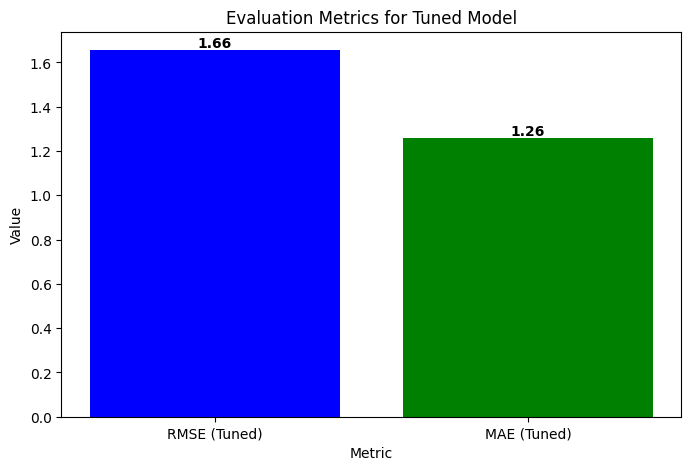

In [29]:
# Plot evaluation metrics
plt.figure(figsize=(8, 5))
plt.bar(['RMSE (Tuned)', 'MAE (Tuned)'], [rmse_tuned_final, mae_tuned_final], color=['blue', 'green'])
for i, v in enumerate([rmse_tuned_final, mae_tuned_final]):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', fontweight='bold')
plt.title('Evaluation Metrics for Tuned Model')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.show()

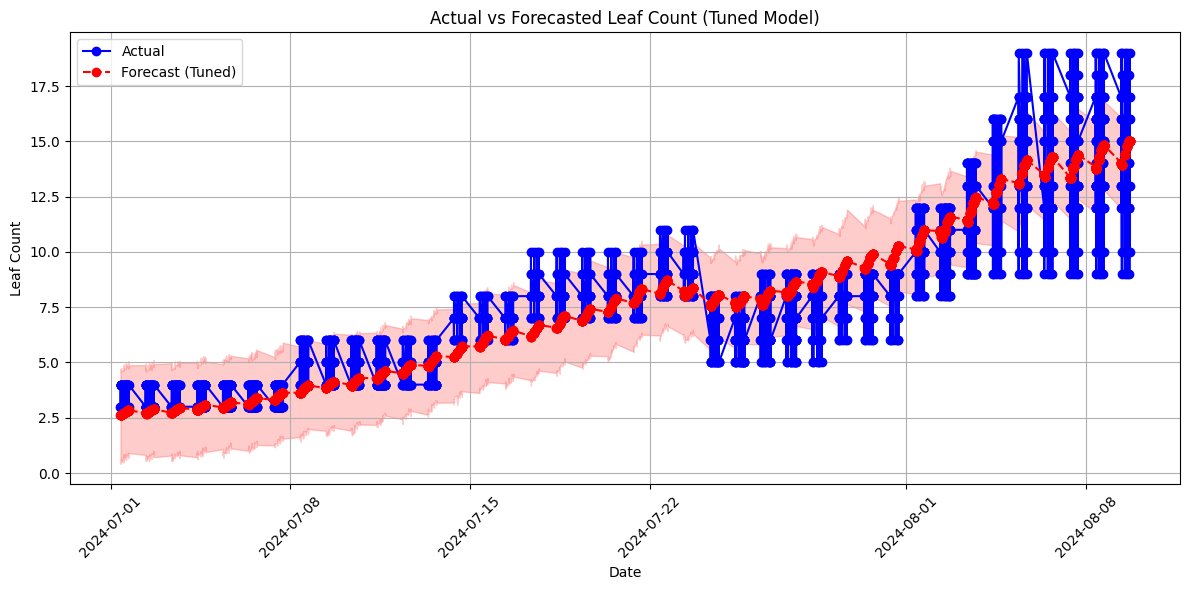

In [30]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(merged_tuned_final['ds'], merged_tuned_final['y'], marker='o', linestyle='-', color='blue', label='Actual')
plt.plot(merged_tuned_final['ds'], merged_tuned_final['yhat'], marker='o', linestyle='--', color='red', label='Forecast (Tuned)')
plt.fill_between(merged_tuned_final['ds'], merged_tuned_final['yhat_lower'], merged_tuned_final['yhat_upper'], color='red', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Leaf Count')
plt.title('Actual vs Forecasted Leaf Count (Tuned Model)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Summary

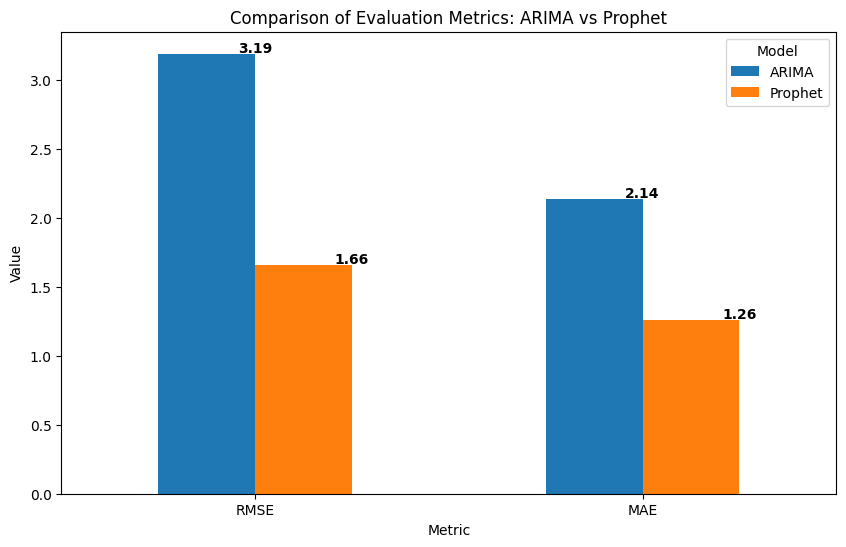

In [50]:
metrics = ['RMSE', 'MAE']
arima_values = [rmse_tuned_arima, mae_tuned_arima]  # Replace with actual ARIMA results
prophet_values = [rmse_tuned_final, mae_tuned_final]  # Replace with actual Prophet results

# Create a DataFrame for easy plotting
comparison_df = pd.DataFrame({
    'Metric': metrics,
    'ARIMA': arima_values,
    'Prophet': prophet_values
})

# Plotting the comparison
comparison_df.set_index('Metric').plot(kind='bar', figsize=(10, 6))

# Add titles and labels
plt.title('Comparison of Evaluation Metrics: ARIMA vs Prophet')
plt.xlabel('Metric')
plt.ylabel('Value')

# Display the values on the bars
for i, col in enumerate(comparison_df.columns[1:]):
    for j, val in enumerate(comparison_df[col]):
        plt.text(j + (i * 0.25), val + 0.01, f'{val:.2f}', ha='center', fontweight='bold')

plt.xticks(rotation=0)
plt.legend(title='Model')
plt.show()